In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import cm

In [18]:
import numpy as np
import pandas as pd
import datetime as dt
import os

In [19]:
# create engine to hawaii.sqlite
Hawaii_Database = os.path.join('Resources','hawaii.sqlite')
Precipitation_Graph = os.path.join('Images','precipitation.png')
Station_Graph = os.path.join('Images','station-histogram.png')
TripTemperature_Graph = os.path.join('Images','temperature.png')
DailyNormal_Graph =os.path.join('Images','daily_normals.png')

# Reflect Tables into SQLAlchemy ORM

In this section, you’ll use Python and SQLAlchemy to perform basic climate analysis and data exploration of your climate database. Complete the following tasks by using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Use the provided [starter notebook](climate_starter.ipynb) and [hawaii.sqlite](Resources/hawaii.sqlite) files to complete your climate analysis and data exploration.

* Use SQLAlchemy’s `create_engine` to connect to your SQLite database.

* Use SQLAlchemy’s `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

* Link Python to the database by creating a SQLAlchemy session.

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# Creating_engine to connect to my sqlite database.
engine = create_engine(f"sqlite:///{Hawaii_Database}")

In [22]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can now view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Precipitation Analysis

To perform an analysis of precipitation in the area, do the following:

* Find the most recent date in the dataset.

* Using this date, retrieve the previous 12 months of precipitation data by querying the 12 previous months of data. **Note:** Do not pass in the date as a variable to your query.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame, and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results by using the DataFrame `plot` method, as shown in the following image:

* Use Pandas to print the summary statistics for the precipitation data.

In [26]:
# Querying how many dates are recorded?
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [27]:
# Finding the earliest date in the data set.
earliest_date = session.query(func.min(Measurement.date))

# Finding the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date))

print(f"Earliest Date: {earliest_date[0]} , Most Recent Date: {latest_date[0]}")

Earliest Date: ('2010-01-01',) , Most Recent Date: ('2017-08-23',)


In [28]:
# Converting the data from string to datetime
date_lastest = dt.datetime.strptime(earliest_date.first()[0], '%Y-%m-%d').date()

# Creating a query data interval
query_date = date_lastest - dt.timedelta(days=365)

# Query the database based on the target date (last 365 days)
Precipitation_Query= session.query(Measurement.date,
                                   Measurement.prcp).filter(Measurement.date > query_date).all()

In [29]:
# Load the query results into a Pandas DataFrame and set the index to the date column.
Precipitation_365 = pd.DataFrame(Precipitation_Query).set_index('date', drop=True)

# Sort the DataFrame values by date
Precipitation_365.sort_values('date',inplace=True)

# Displaying the DataFrame
Precipitation_365.head()

,prcp
date,
2010-01-01,0.08
2010-01-01,0.21
2010-01-01,0.15
2010-01-01,0.15
2010-01-01,0.05


In [30]:
# Drop the NAN values
Precipitation_365_Clean = Precipitation_365.loc[Precipitation_365['prcp'].isnull()==False]

<Figure size 432x288 with 0 Axes>

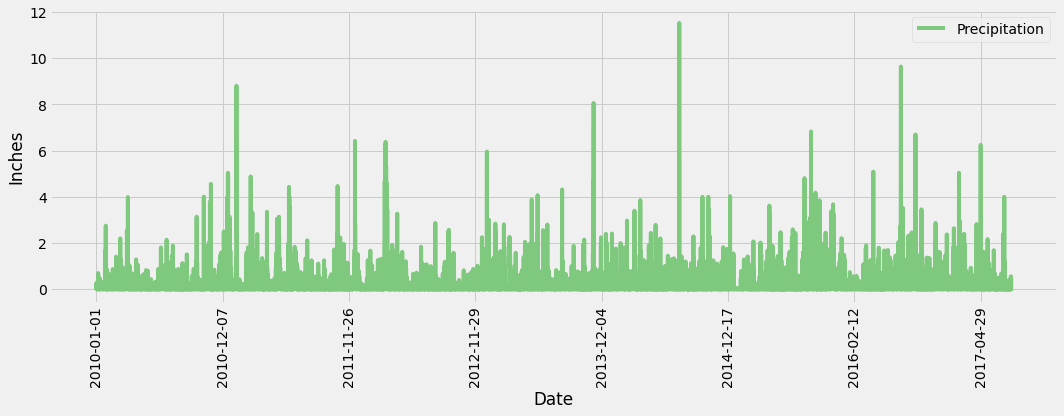

In [31]:
# Plot the results using the DataFrame plot method
plt.figure()
ax = Precipitation_365_Clean.plot(figsize=(15,6),rot=90,colormap='Accent')
ax.set_ylabel('Inches')
ax.set_xlabel('Date')
ax.legend(["Precipitation"]);
plt
plt.tight_layout()
plt.savefig(Precipitation_Graph)

In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precipitation_365_Clean.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


## Exploratory Station Analysis

To perform an analysis of stations in the area, do the following:

* Design a query to calculate the total number of stations in the dataset.

* Design a query to find the most active stations (the stations with the most rows).

    * List the stations and observation counts in descending order.

    * Which station id has the highest number of observations?

    * Using the most active station id, calculate the lowest, highest, and average temperatures.

    * **Hint:** You will need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

        
* Design a query to retrieve the previous 12 months of temperature observation data (TOBS).

In [33]:
# Querying the total number of stations in the dataset
available_stations = session.query(Station.id).count()
print(f"There are {available_stations} stations are available in this dataset.")

There are 9 stations are available in this dataset.


In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Station.station,func.count(Station.station)).filter(
                                        Measurement.station == Station.station).group_by(
                                        Station.station).order_by(
                                        func.count(Station.station).desc()).all()

most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

###### Using the most active station id from the previous query calculate the lowest, highest, and average temperature.

In [35]:
# querying the most active station
most_active_station_id  = most_active_stations[0][0]

# lowest temperature recorded
lowest_temperature = session.query(Measurement.tobs).filter(
                                Measurement.station == most_active_station_id).order_by(
                                Measurement.tobs.asc()).first()

# highest temperature recorded
highest_temperature = session.query(Measurement.tobs).filter(
                                Measurement.station == most_active_station_id).order_by(
                                Measurement.tobs.desc()).first()

# average temperature
average_temperature = session.query(func.avg(Measurement.tobs)).filter(
                                Measurement.station == most_active_station_id).first()

print(f"The lowest temperature recorded at station {most_active_station_id} is {lowest_temperature[0]}°")
print(f"The highest temperature recorded at station {most_active_station_id} is {highest_temperature[0]}°")
print(f"The average temperature recorded at station {most_active_station_id} is {round(average_temperature[0],2)}°")

The lowest temperature recorded at station USC00519281 is 54.0°
The highest temperature recorded at station USC00519281 is 85.0°
The average temperature recorded at station USC00519281 is 71.66°


###### Using the most active station id, query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [38]:
# Querying the last 12 months of temperature observation data for this station 
Temp_Obs_12Months = session.query(Measurement.date, Measurement.tobs).filter(
                                    Measurement.date > query_date).filter(
                                    Measurement.station == most_active_station_id).statement

# Using Pandas read_sql_query to load a query statement directly into the DataFrame
Temp_Observations = pd.read_sql_query(Temp_Obs_12Months, session.bind).set_index('date', drop=True)

# Dropping the NAN values if there are any in the data set
Temperature_Obs_Clean = Temp_Observations.loc[Temp_Observations['tobs'].isnull()==False]

Temperature_Obs_Clean.describe()

,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


<Figure size 432x288 with 0 Axes>

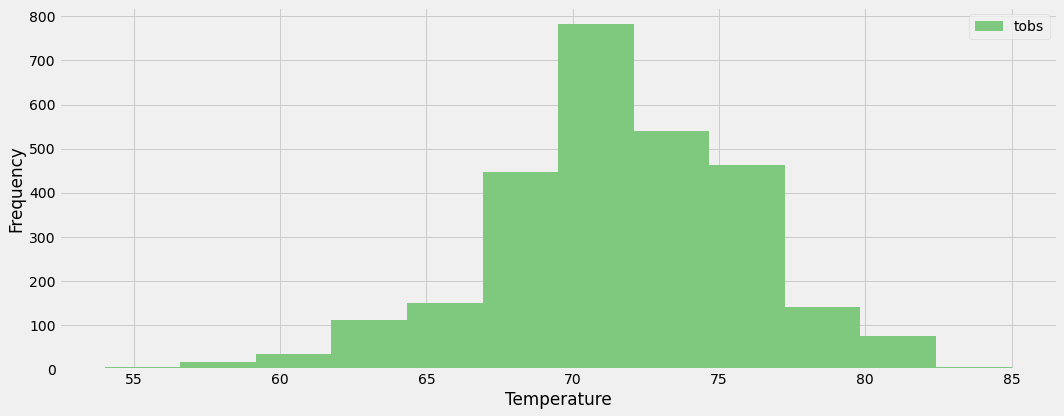

In [24]:
# Plot the results as a histogram
plt.figure()
ax = Temperature_Obs_Clean.plot.hist(figsize=(15,6),bins=12,colormap='Accent')
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.savefig(Station_Graph)

###### Close session

In [29]:
# Close Session
session.close()